# Построение ML-продукта для предсказания повторной покупки покупателя
**Описание проекта**
<br>Предоставлено три файла - каждый файл это отдельный интернет-магазин:
- `marketplace` – мультикатегорийный магазин с посещаемостью более 8-ми млн сессий в месяц, 
- `apparel` – магазин одежды, по характеристикам похожий на маркетплейс, 
- `gifts` - очень маленький магазин подарков.

<br>В данных - обезличенная история покупок клиентов за определенный период.

**Цель проекта**
- Необходимо создать решение для предсказания совершения покупателем повторной покупки в течение ближайших 30-ти дней 

**Задачи**
- Необходимо выбрать и обосновать метрику (Заказчику важен положительный класс покупателей),
- предложить решение, способное с высокой вероятностью предсказывать поведение клиентов.

**Ход исследования**
- загрузка данных и ознакомление с ними,
- EDA,
- создание новых признаков (при необходимости),
- отбор финального набора обучающих признаков,
- подготовка данных для обучения,
- выбор и обучение моделей (разных архитектур),
- оценка качества предсказания лучшей модели на тестовой выборке,
- анализ важности признаков лучшей модели,
- отчёт по проведённому исследованию.

**Описание данных**
<br>`client_id` - идентификатор клиента,
<br>`quantity` - количество товара в заказе,
<br>`price` - цена единицы товара в заказе,
<br>`message_id` - идентификатор сообщения из рассылки,
<br>`date` - дата покупки

**Выбор метрик**
- данная задача является задачей классификации,
  <br>ориентированная на временные ряды,
- метрики для оптимизации будут выбраны после ознакомления с данными,
- предварительно - `ROC-AUC`

## Настройка рабочей среды

In [1]:
# !pip list
# !pip install pandas
# !pip install matplotlib
# !pip install seaborn
# !pip install pyarrow

In [2]:
import random
import numpy as np
import pandas as pd
# import seaborn as sns
# import matplotlib.pyplot as plt

### Импорт своего класса

In [3]:
from research_class import DatasetExplorer

Установка констант

In [4]:
RANDOM_STATE = 42

Установка random_state

In [5]:
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

## Загрузка и первичный EDA

In [6]:
try:
    marketplace = pd.read_csv('data/marketplace-purchases.csv', parse_dates=['date', 'created_at'])
    apparel = pd.read_csv('data/apparel-purchases.csv', parse_dates=['date'])
    gifts = pd.read_csv('data/gifts-purchases.csv', parse_dates=['date'])
    h22 = pd.read_csv('data/holidays_calendar_2022.csv')
    h23 = pd.read_csv('data/holidays_calendar_2023.csv')
    print('загружено из каталога "data"')
except:
    marketplace = pd.read_csv(userdata.get('marketplace_path'), parse_dates=['date', 'created_at'])
    apparel = pd.read_csv(userdata.get('apparel_path'), parse_dates=['date'])
    gifts = pd.read_csv(userdata.get('gifts_path'), parse_dates=['date'])
    h22 = pd.read_csv(userdata.get('h22_path'))
    h23 = pd.read_csv(userdata.get('h23_path'))
    print('загружено из каталога Google Drive')

загружено из каталога "data"


### Holidays

In [7]:
def date_preparation(data, year):
    '''
    - на вход принимает датасет с праздниками и год этого датасета
    - возвращает обработанный датасет
    '''
    data = data.reset_index(drop=True).T[:13]
    data = data.set_axis(data.iloc[0], axis=1)[1:]
    data.insert(0, 'month', range(1, len(data) + 1))
    data.insert(0, 'year', year)
    data = data.replace(['\+', '\*'], '', regex=True)
    data[year] = data[year].str.split(',')
    data = data.explode(year)
    data = data.rename(columns={year: 'day'})
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    
    return data

In [8]:
h22 = date_preparation(h22, 2022)
h23 = date_preparation(h23, 2023)
holidays = pd.concat([h22, h23], ignore_index=True)
holidays.sample(5)

Год/Месяц,year,month,day,date
24,2022,2,27,2022-02-27
6,2022,1,7,2022-01-07
152,2023,3,18,2023-03-18
209,2023,9,17,2023-09-17
237,2023,12,17,2023-12-17


#### Выводы и наблюдения
- подготовлен датасет, в котором перечислены все выходные и праздничные дни в РФ в 2022 и 2023 годах

### Marketplace

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  datetime64[ns]
 5   date        48182 non-null  datetime64[ns]
dtypes: datetime64[ns](2), float64(1), int64(2), object(1)
memory usage: 2.2+ MB


,client_id,quantity,price,message_id,created_at,date
38957,1515915625520049365,1,58798.0,1515915625520049365-1561-63f5b21423c41,2023-02-22,2023-02-22 07:54:26
17593,1515915625533002613,1,6299.0,1515915625517580463-1596-640181a7da72a,2023-03-03,2023-03-03 06:52:27
29253,1515915625559756457,1,130998.0,1515915625519524273-2034-64d9fe880cc04,2023-08-14,2023-08-14 13:52:07
1219,1515915625470243155,1,4108.0,1515915625470243155-2100-6501b27795027,2023-09-14,2023-09-14 10:14:26
6432,1515915625497262383,1,7198.0,1515915625497262383-1244-6367468693386,2022-11-07,2022-11-07 09:58:39


количество полных дубликатов строк: 2159


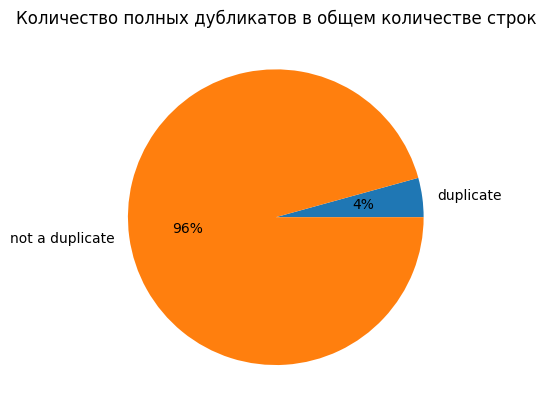

количество уникальных значений client_id:
		17787
количество уникальных значений client_id в общем количестве client_id:
		36.916%


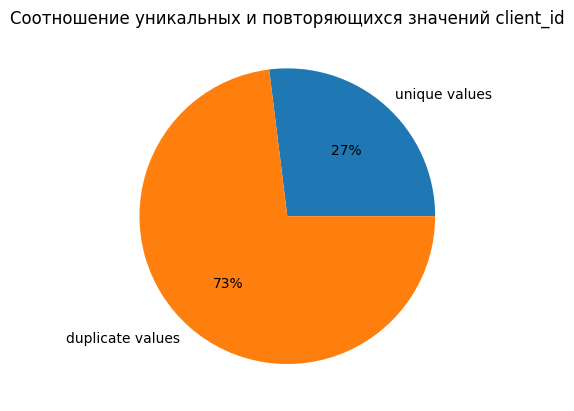

количество уникальных значений message_id:
		20940
количество уникальных значений message_id в общем количестве message_id:
		43.460%


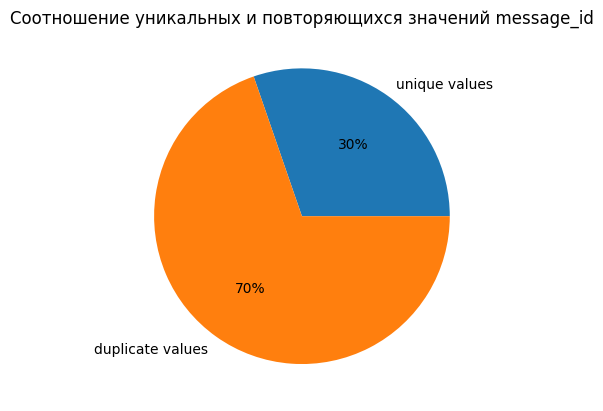

описание quantity:
		count    48182.000000
mean         1.017413
std          0.540592
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max         50.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 15


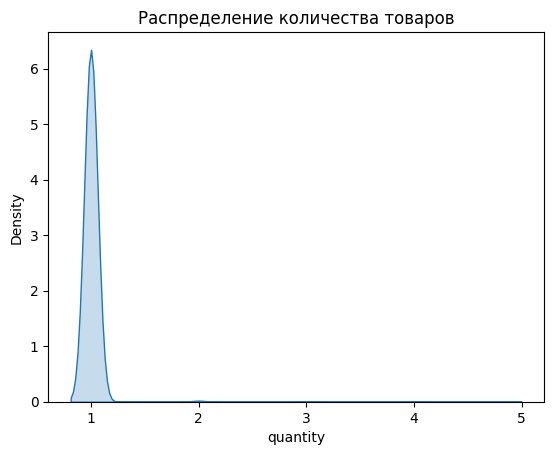

описание price:
		count    4.818200e+04
mean     2.791895e+04
std      4.492274e+04
min      0.000000e+00
25%      1.204250e+03
50%      9.998000e+03
75%      3.599800e+04
max      1.299998e+06
Name: price, dtype: float64
количество уникальных значений price: 4991


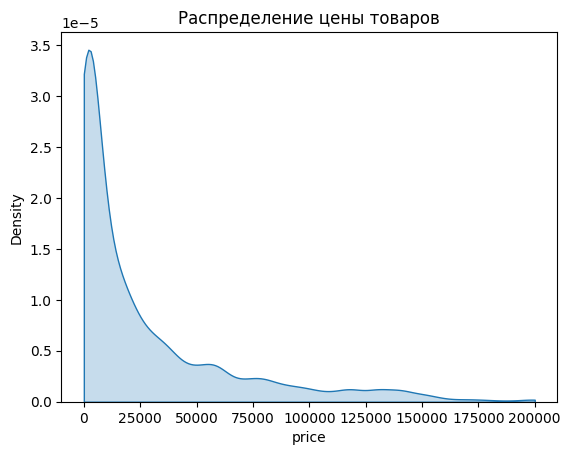

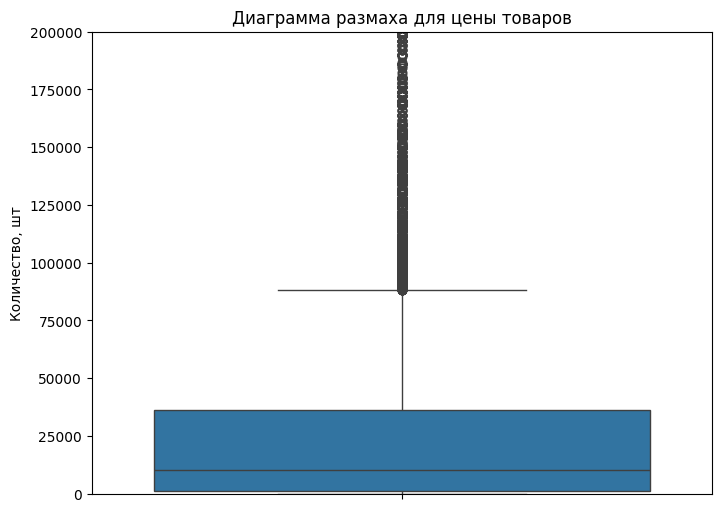

Первая запись в датафрейме: 2022-10-26 08:35:46
		Последняя запись в датафрейме: 2023-10-26 13:34:11


In [9]:
explorer_marketplace = DatasetExplorer(marketplace, y_lim=200000)
explorer_marketplace.explore_dataset()  # 48182

In [10]:
print(f"""Количество совпадений в признаках created_at и date по отношению ко всему датафрейму:
{(marketplace['created_at'] == marketplace['date'].dt.date).sum() / marketplace.shape[0] * 100:.0f}%""")

Количество совпадений в признаках created_at и date по отношению ко всему датафрейму:
100%


Удаление дублирующего признака

In [11]:
marketplace = marketplace.drop(['date'], axis=1)

In [12]:
marketplace.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.8+ MB


#### Выводы и наблюдения
- пропусков в данных не обнаружено;
- количество полных дубликатов строк составляет около 5% от датафрейма,
  <br>но нет понимания - действительно ли это дубликаты (возможно - нусколько товаров
  <br>из одной категории, но сразными артикулами, принимаю решение оставить их
  <br>и использовать в дальнейшем при агрегации;
- количество уникальных значений `client_id` составляет чуть больше трети от всех,
  <br>что свидетельствует о повторных действиях клиентов;
-  медиана и среднее в `quantity` практически равны, что говорит о нормальности распределения;
-  в признаке `price` среднее значение больше медианного, наблюдается правосторонняя асимметрия,
  <br>распределение отличается от нормального;
- в признаке `price`обнаружено большое количество выбросов, удалять их нет необходимости,
  <br>т.к. они помогут в дальнейшем исследовании;
- период записей в датафрейме - 1 год (с 26.10.22 по 26.10.23);
- признаки `created_at` и `date` полностью совпадают, принимаю решение удалить `date`,
  <br>посколько собираюсь агрегировать покупки по каждому клиенту за день, т.к. Заказчика интересует
  <br>возвращение клиента через дни, а не часы.

### Apparel

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 133104 entries, 0 to 133103
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   client_id       133104 non-null  int64         
 1   quantity        133104 non-null  int64         
 2   price           133104 non-null  float64       
 3   date            133104 non-null  datetime64[ns]
 4   message_id      133104 non-null  object        
 5   recommended_by  133104 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 6.1+ MB


,client_id,quantity,price,date,message_id,recommended_by
102111,1515915625966130065,1,210.0,2023-08-04,1515915625966130065-13598-64cd08bcf10da,bulk_message
115476,1515915625764066035,1,346.0,2022-12-23,1515915625764066035-5286-62c52c0348b65,bulk_message
100772,1515915625764187190,1,2499.0,2023-06-29,1515915625764187190-13406-649aaef97a8c2,bulk_message
122255,1515915625817356226,1,2563.0,2022-11-26,1515915625817356226-8169-6381ebc51689f,bulk_message
82710,1515915625559323786,1,199.0,2023-06-28,1515915625776574312-13406-649aafca60b77,bulk_message


количество полных дубликатов строк: 59250


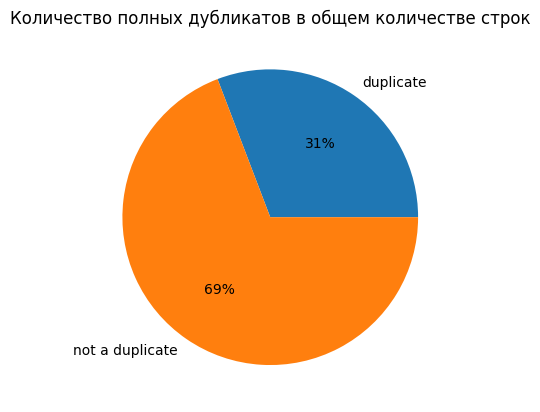

количество уникальных значений client_id:
		28891
количество уникальных значений client_id в общем количестве client_id:
		21.706%


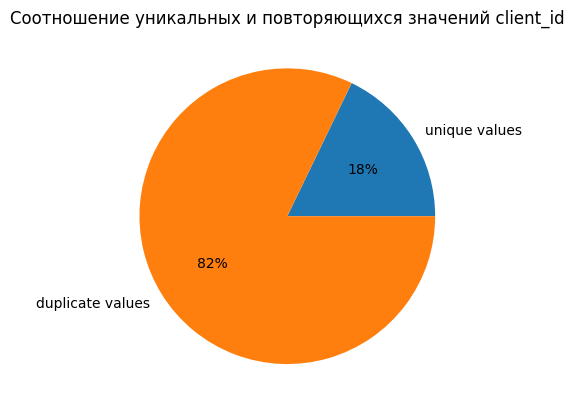

количество уникальных значений message_id:
		25426
количество уникальных значений message_id в общем количестве message_id:
		19.102%


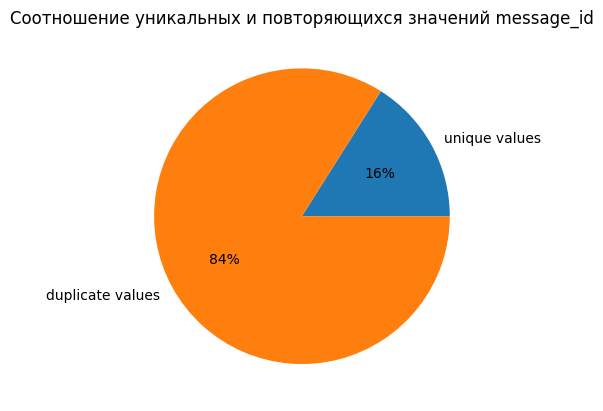

описание quantity:
		count    133104.000000
mean          1.004312
std           0.149315
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max          30.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 12


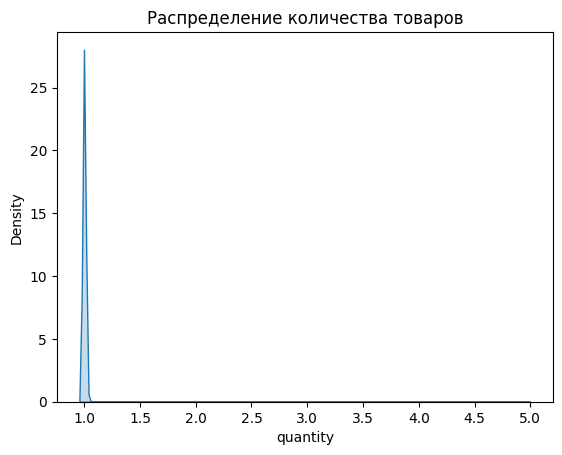

описание price:
		count    133104.000000
mean       1110.433067
std        1257.080854
min           1.000000
25%         280.000000
50%         799.000000
75%        1499.000000
max       63499.000000
Name: price, dtype: float64
количество уникальных значений price: 3335


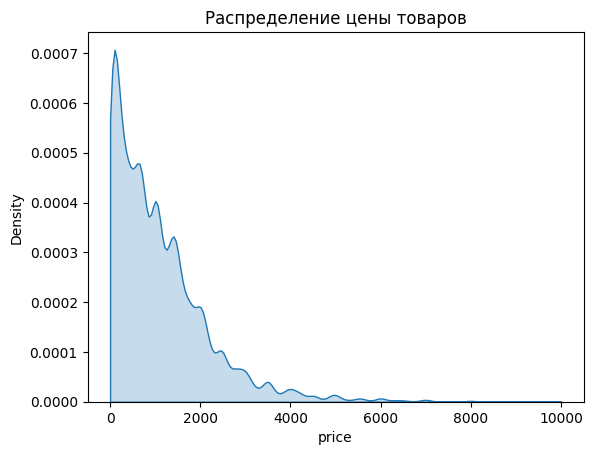

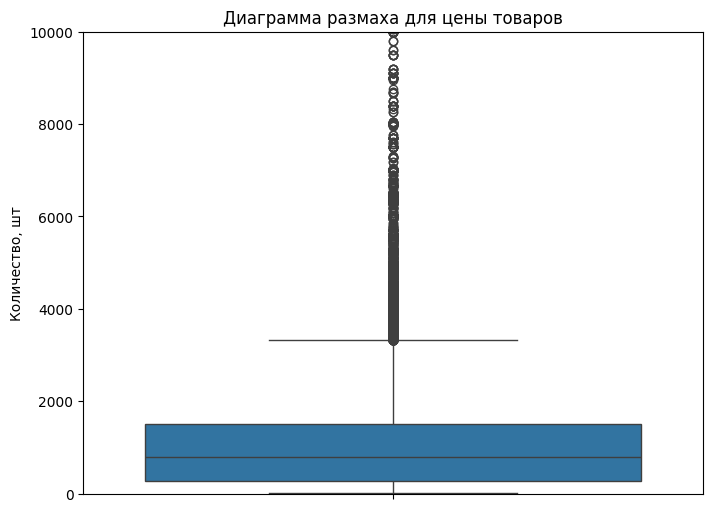

Первая запись в датафрейме: 2022-10-26 00:00:00
		Последняя запись в датафрейме: 2023-10-26 00:00:00


In [13]:
explorer_apparel = DatasetExplorer(apparel, y_lim=10000)
explorer_apparel.explore_dataset()  # 133104

In [14]:
print(f"""уникальные значения recommended_by:
{apparel['recommended_by'].value_counts().sort_index(ascending=False)}""")

уникальные значения recommended_by:
recommended_by
bulk_message    133104
Name: count, dtype: int64


Удаление признака recommended_by

In [15]:
apparel = apparel.drop(['recommended_by'], axis=1)

#### Выводы и наблюдения
- пропусков в данных не обнаружено;
- количество полных дубликатов строк составляет около 30% от датафрейма,
  <br>но нет понимания - действительно ли это дубликаты (возможно - нусколько товаров
  <br>из одной категории, но сразными артикулами, принимаю решение оставить их
  <br>и использовать в дельнейшем при агрегации;
- количество уникальных значений `client_id` составляет около 20% от всех,
  <br>что свидетельствует о повторных действиях клиентов;
- медиана и среднее в `quantity` практически равны, что говорит о нормальности распределения;
- в признаке `price` среднее значение больше медианного, наблюдается правосторонняя асимметрия,
  <br>распределение отличается от нормального;
- в признаке `price` обнаружено большое количество выбросов, удалять их нет необходимости,
  <br>т.к. они помогут в дальнейшем исследовании;
- период записей в датафрейме - 1 год (с 26.10.22 по 26.10.23);
- в признаке `recommended_by` только одно значение, принимаю решение удалить данный признак,
  <br>как неинформативный.

### Gifts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   client_id       811 non-null    int64         
 1   quantity        811 non-null    int64         
 2   price           811 non-null    float64       
 3   date            811 non-null    datetime64[ns]
 4   message_id      811 non-null    object        
 5   recommended_by  811 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 38.1+ KB


,client_id,quantity,price,date,message_id,recommended_by
804,1515915625869270636,1,1891.0,2022-11-23,1515915625835006252-8044-637ccf9a372d3,bulk_message
429,1515915625853062360,1,49990.0,2023-01-12,1515915625853062360-9331-63c0128a7a5f2,bulk_message
233,1515915625817415471,1,34990.0,2023-03-09,1515915625817415471-10707-6405f1b769dc1,bulk_message
294,1515915625803892965,1,19990.0,2023-05-22,1515915625864123161-12742-646b14f264f93,bulk_message
551,1515915625803180879,1,3073.0,2023-06-29,1515915625951750973-13766-649d8889ee133,bulk_message


количество полных дубликатов строк: 56


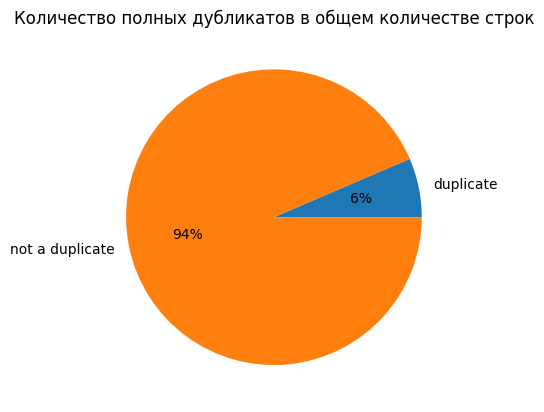

количество уникальных значений client_id:
		326
количество уникальных значений client_id в общем количестве client_id:
		40.197%


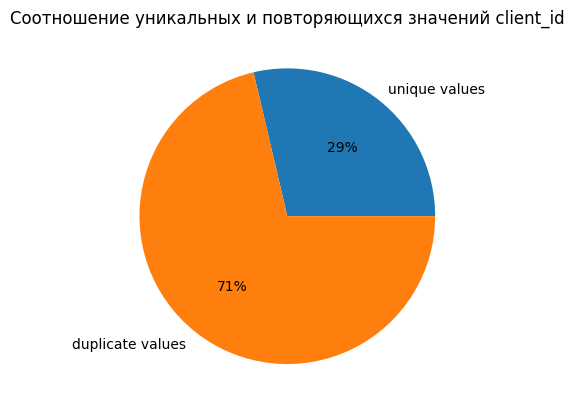

количество уникальных значений message_id:
		342
количество уникальных значений message_id в общем количестве message_id:
		42.170%


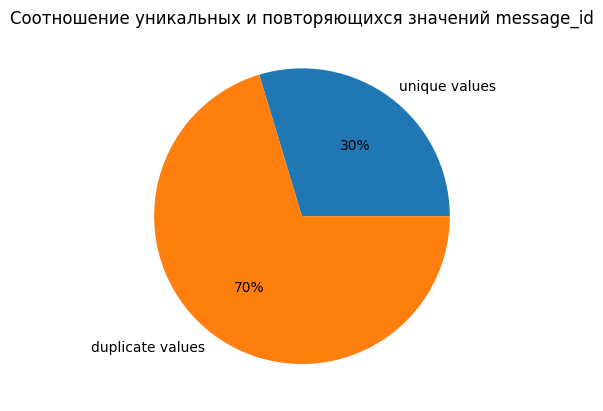

описание quantity:
		count    811.000000
mean       1.003699
std        0.060745
min        1.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000
Name: quantity, dtype: float64
количество уникальных значений quantity: 2


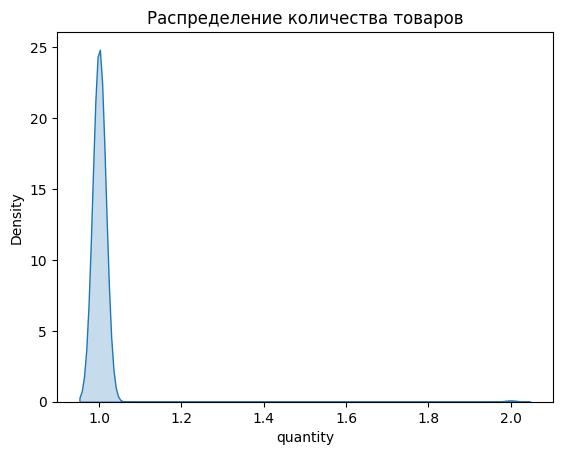

описание price:
		count       811.000000
mean      14468.795314
std       17774.341837
min         656.000000
25%        3878.000000
50%        7533.000000
75%       17938.000000
max      173586.000000
Name: price, dtype: float64
количество уникальных значений price: 598


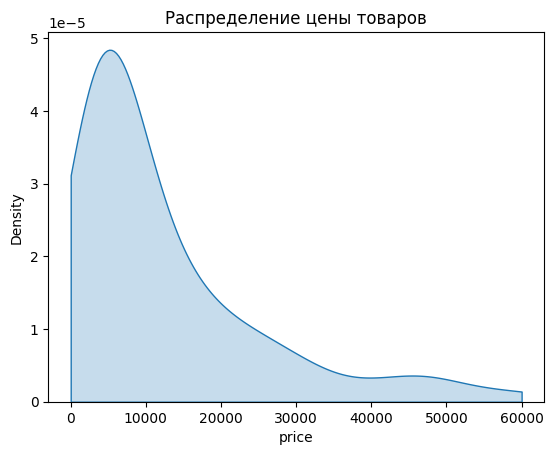

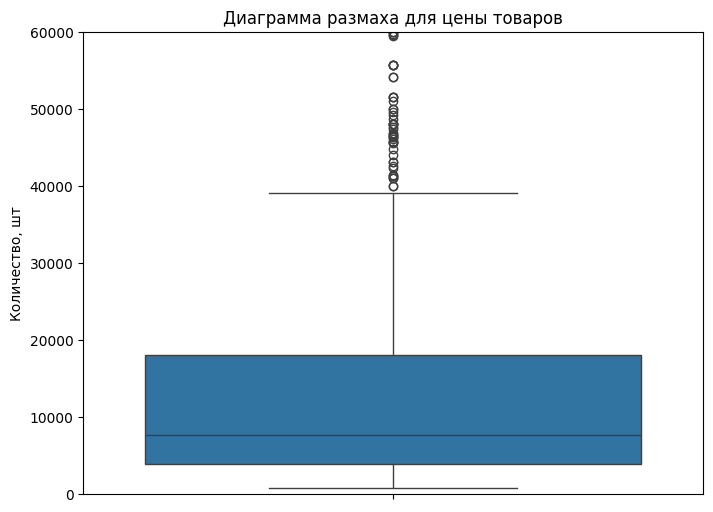

Первая запись в датафрейме: 2022-10-26 00:00:00
		Последняя запись в датафрейме: 2023-10-24 00:00:00


In [16]:
explorer_gifts = DatasetExplorer(gifts, y_lim=60000)
explorer_gifts.explore_dataset()  # 811

In [17]:
print(f"""уникальные значения recommended_by:
{gifts['recommended_by'].value_counts().sort_index(ascending=False)}""")

уникальные значения recommended_by:
recommended_by
bulk_message    811
Name: count, dtype: int64


Удаление признака recommended_by

In [18]:
gifts = gifts.drop(['recommended_by'], axis=1)

In [19]:
gifts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 811 entries, 0 to 810
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   811 non-null    int64         
 1   quantity    811 non-null    int64         
 2   price       811 non-null    float64       
 3   date        811 non-null    datetime64[ns]
 4   message_id  811 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 31.8+ KB


#### Выводы и наблюдения
- пропущенных значений в данных не обнаружено;
- количество полных дубликатов строк составляет около 6% от датафрейма,
  <br>но нет понимания - действительно ли это дубликаты (возможно - нусколько товаров
  <br>из одной категории, но сразными артикулами, принимаю решение оставить их
  <br>и использовать в дельнейшем при агрегации;
- количество уникальных значений `client_id` составляет около трети от всех,
  <br>что свидетельствует о повторных действиях клиентов;
- количество уникальных значений `message_id` составляет около трети от всех;
- медиана и среднее в `quantity` практически равны, что говорит о нормальности распределения;
- в признаке `price` среднее значение больше медианного, наблюдается правосторонняя асимметрия,
  <br>распределение отличается от нормального;
- в признаке `price` обнаружено большое количество выбросов, удалять их нет необходимости,
  <br>т.к. они помогут в дальнейшем исследовании;
- период записей в датафрейме - 1 год (с 26.10.22 по 24.10.23);
- в признаке `recommended_by` только одно значение, принимаю решение удалить данный признак,
  <br>как неинформативный.

## Предобработка, создание признаков

### Marketplace

In [21]:
marketplace.info()
marketplace.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48182 entries, 0 to 48181
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   48182 non-null  int64         
 1   quantity    48182 non-null  int64         
 2   price       48182 non-null  float64       
 3   message_id  48182 non-null  object        
 4   created_at  48182 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 1.8+ MB


,client_id,quantity,price,message_id,created_at
28026,1515915625546751064,1,1101.0,1515915625546751064-2032-64d60959d36d1,2023-08-11
24268,1515915625584894537,1,2.0,1515915625584894537-2136-6517ffe2c22ba,2023-09-30
9964,1515915625518845400,1,13279.0,1515915625518845400-1600-6401e235e8f54,2023-03-03
28232,1515915625555376056,1,29999.0,1515915625555376056-2034-64d9fe8f1e5d1,2023-08-23
22936,1515915625572776734,1,1801.0,1515915625572776734-2122-65125dd4e4c30,2023-09-26


Группировка по дням и клиентам

In [38]:
grouped_mp = (marketplace
              .groupby(['client_id', 'created_at'])
              .agg({'quantity': 'sum', 
                    'price': 'sum', 
                    'message_id': 'sum'})
              .reset_index()
             )

grouped_mp.info()
grouped_mp.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23926 entries, 0 to 23925
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   client_id   23926 non-null  int64         
 1   created_at  23926 non-null  datetime64[ns]
 2   quantity    23926 non-null  int64         
 3   price       23926 non-null  float64       
 4   message_id  23926 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 934.7+ KB


,client_id,created_at,quantity,price,message_id
19805,1515915625564149129,2022-11-26,1,27998.0,1515915625564149129-1306-6380674979608
12475,1515915625532873125,2022-12-09,2,29996.0,1515915625532873125-1353-63931667cbdfb15159156...
22905,1515915625580377661,2023-09-28,1,508.0,1515915625580377661-2129-65141387e38d8
4572,1515915625516275391,2023-05-19,2,37996.0,1515915625557166003-1814-6466ecaa343f515159156...
17025,1515915625554058400,2023-03-01,2,200.0,1515915625554058400-1587-63fef1204fc2c15159156...


Установка даты в индекс

In [39]:
grouped_mp.set_index('created_at', inplace=True)
grouped_mp.sort_index(inplace=True)
grouped_mp.head(5)

,client_id,quantity,price,message_id
created_at,,,,
2022-10-26,1515915625562386426,1,10598.0,1515915625535383551-394-618c9257e304b
2022-10-27,1515915625519806198,9,461985.0,1515915625497997799-446-61adac871e8c6151591562...
2022-10-28,1515915625519129510,2,1598.0,1515915625535474977-1212-635bd5f98cbd315159156...
2022-10-28,1515915625561853956,2,36812.0,1515915625561853956-1212-635bd5efaaf7415159156...
2022-10-28,1515915625557332642,1,682.0,1515915625556320132-1212-635bd5f6463cb


Добавление целевого признака
- если в течение 30-ти дней произведена повторная покупка, то значение = 1
- если покупки не случилось, то ставим нулевое значение
- каждая повторная покупка обнуляет отсчёт по клиенту

Добавление информации о днях недели

Изучение сезонности

Проверка корреляций

In [ ]:
marketplace.info()